In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import string
import gensim
import warnings
warnings.filterwarnings("ignore")
import emoji
import seaborn as sns
import re
import html 
import collections
# import enchant
from wordcloud import WordCloud


from ftfy import fix_text
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CMELAB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CMELAB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


# Part 1: Cleaning Data

The source text for this assignment requires extensive cleaning before being analyzed by a machine learning algorithm.
We start with the following basic data cleaning steps :
   1. remove tag and html attributes
   2. replace html character code with an asci equivalent
   3. remove url
   4. lower letters
   5. remove mentions

# Read the US_airline_tweets.csv file 

In [2]:
## Read data 
filename = "US_airline_tweets.csv"
data = pd.read_csv(filename, encoding='utf-8')
data.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


## Remove html tags and attributes

In [3]:
tweet_text = data['text']
tweet_text.head()

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

In [4]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext
data['text'] =  data['text'].apply(lambda x: cleanhtml(x))
data['text'][4]

'@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€\x9d wonâ€™t go away :)'

## Html character codes (i.e., &...;) are replaced with an ASCII equivalent.

In [5]:
data['text'] = data['text'].apply(lambda x:  html.unescape(x) ) 
data['text'].head()

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 6 columns):
id                 11541 non-null float64
sentiment          11541 non-null object
negative_reason    9178 non-null object
user               11541 non-null object
retweet_count      11541 non-null int64
text               11541 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 541.1+ KB


Here we analyze the following statistics and its effect on the sentment:
1. count_words in tweets
2. count of mentions
3. count of hastags
4. count of capital words
5. number of question and exclamation marks
6. count of urls
7. count of emojis

In [7]:
#Descriptive analysis of the text
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(data.text)
df_eda['sentiment'] = data.sentiment
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment
0,10,1,0,0,0,0,0,positive
1,17,1,0,0,0,0,0,negative
2,11,1,0,0,0,0,0,negative
3,25,1,0,1,0,0,0,negative
4,16,1,0,1,0,0,1,positive


Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
negative   9178.0  20.368599  6.064759  2.0  17.0  22.0  25.0  36.0
positive   2363.0  14.690224  7.304182  2.0   9.0  15.0  21.0  50.0


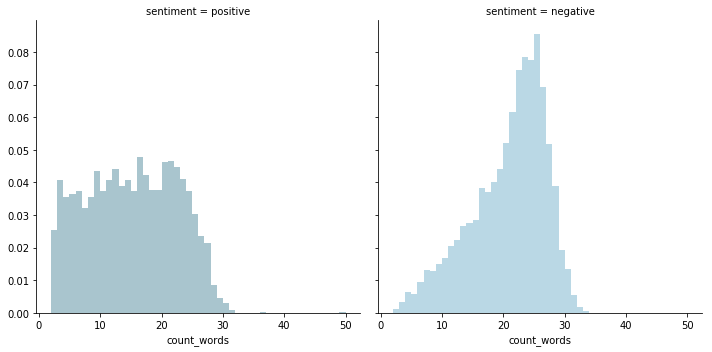

In [8]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', height=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
show_dist(df_eda,"count_words") #Negative tweets tend to show more words

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
positive   2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


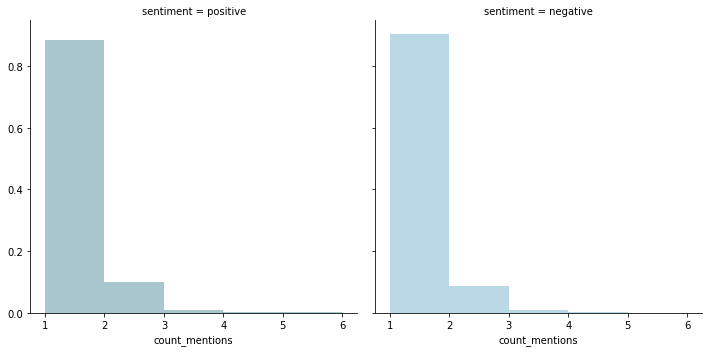

In [9]:
show_dist(df_eda,"count_mentions") #Plot show that mentions do not influence the sentiment

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  0.233602  0.615371  0.0  0.0  0.0  0.0  6.0
positive   2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


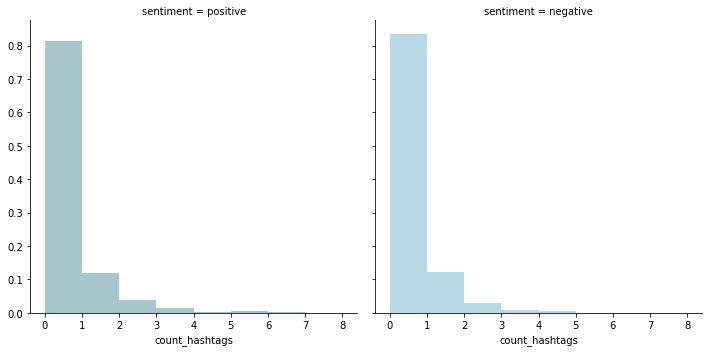

In [10]:
show_dist(df_eda,"count_hashtags") #Plot show that hashtags do not influence the sentiment

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   9178.0  0.427762  1.019298  0.0  0.0  0.0  1.0  22.0
positive   2363.0  0.456200  1.232192  0.0  0.0  0.0  0.0  20.0


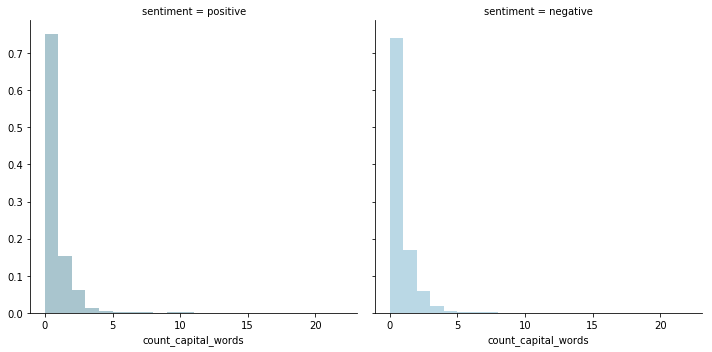

In [11]:
show_dist(df_eda,"count_capital_words") #Plots show that number of capital words do not influence the sentiment

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   9178.0  0.634125  1.143958  0.0  0.0  0.0  1.0  27.0
positive   2363.0  0.892510  1.199191  0.0  0.0  1.0  1.0  13.0


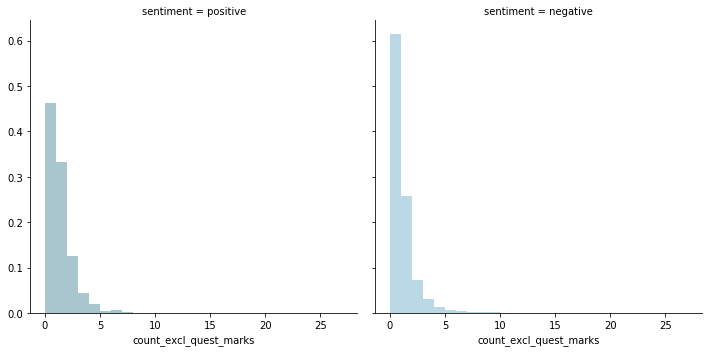

In [12]:
show_dist(df_eda,"count_excl_quest_marks") #Plots show that number of exclamation question marks do not influence the sentiment

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
positive   2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


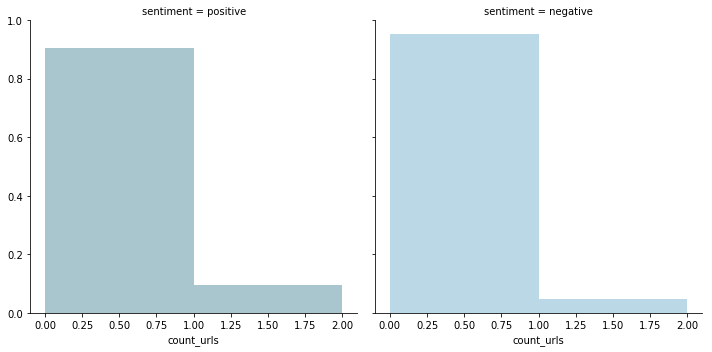

In [13]:
show_dist(df_eda,"count_urls") #Plots show that number of url has no effect on the sentiment

Descriptive stats for count_emojis
----------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   9178.0  0.012639  0.141804  0.0  0.0  0.0  0.0   4.0
positive   2363.0  0.067287  0.994545  0.0  0.0  0.0  0.0  32.0


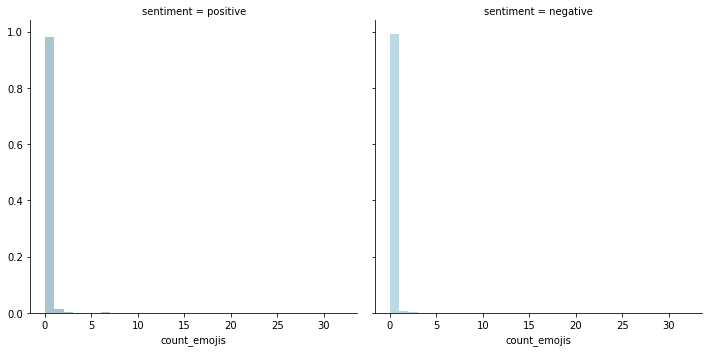

In [14]:
show_dist(df_eda,"count_emojis") #number of emoji has no effect on sentiment

# All URLs are removed

In [15]:
data['text'] = data['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data['text'] = data['text'].apply(lambda x:  fix_text(x) ) 
data['text'].head()

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

# Replace Special Character and abbrevations

In [16]:
# emojies : happy, sad... may contain relevant information about the text sentiment so they are kept and convected to corresponding meaning in text
data['text'] = data['text'].apply(lambda x:  emoji.demojize(x) ) 

In [17]:
# Number of unique words in current data set
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens
import itertools
token_data = data['text'].apply(lambda x: tokenization(x))
before_cleaning_number=len(set(list(itertools.chain.from_iterable(token_data))))
print(before_cleaning_number)

14606


# Additional clearnups

In [18]:
# All characters in the text are in lowercase
data['text'] = data['text'].apply(lambda x: x.lower())

In [19]:
#Most mention words corresponds to the name of the airline which is an important parameter to consider when exploring the data
allmentions = data['text'].str.extractall(r"(@[A-Za-z0-9]+)")
allmentions_words = allmentions[0][:]
freq_mentions = allmentions_words.value_counts(dropna=False)
print(freq_mentions)

@united             3192
@usairways          2607
@americanair        2462
@southwestair       1788
@jetblue            1519
@virginamerica       344
@delta                60
@phlairport           17
@imaginedragons       17
@dfwairport           12
@fortunemagazine      10
@spiritairlines        8
@love                  8
@cowboycerrone         7
@aircanada             6
@cnn                   6
@wsj                   6
@staralliance          6
@gg8929                6
@dulles                6
@expedia               5
@virginatlantic        5
@ladygaga              4
@silverairways         4
@tsa                   4
@velourlive            4
@carrieunderwood       4
@southwest             4
@ny                    4
@kylejudah             4
                    ... 
@priceline             1
@barclaycardus         1
@matt                  1
@waltdisneyworld       1
@datingrev             1
@d                     1
@yeniettelswood        1
@jordnnicole7          1
@stephenrodrick        1


In [20]:
#print(freq_mentions.values)
#We only consider the airlines that have sizable number of data (more than 60)
major_airlines=freq_mentions.index.values[freq_mentions.values>60]
print(major_airlines)

['@united' '@usairways' '@americanair' '@southwestair' '@jetblue'
 '@virginamerica']


In [21]:
data['airline'] = np.nan
for airline in major_airlines:
    data['airline'][data['text'].str.contains(airline)] = airline

print(data['airline'])

0        @virginamerica
1        @virginamerica
2        @virginamerica
3        @virginamerica
4        @virginamerica
5        @virginamerica
6        @virginamerica
7        @virginamerica
8        @virginamerica
9        @virginamerica
10       @virginamerica
11       @virginamerica
12       @virginamerica
13       @virginamerica
14       @virginamerica
15       @virginamerica
16       @virginamerica
17       @virginamerica
18       @virginamerica
19       @virginamerica
20       @virginamerica
21       @virginamerica
22       @virginamerica
23       @virginamerica
24       @virginamerica
25       @virginamerica
26       @virginamerica
27       @virginamerica
28       @virginamerica
29       @virginamerica
              ...      
11511      @americanair
11512      @americanair
11513      @americanair
11514      @americanair
11515      @americanair
11516      @americanair
11517      @americanair
11518      @americanair
11519      @americanair
11520      @americanair
11521      @amer

In [22]:
#Remove mentions
data['text'] = data['text'].replace(r"@[A-Za-z0-9]+", '', regex=True)

# Remove all stop words

In [23]:
# remove the stp words considering the stop_words file provided for this assignment
stop = [line.rstrip('\n') for line in open('stop_words.txt')]
print(stop)

['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'cont

In [24]:
data['text'].apply(lambda x: ''.join([word for word in x.split() if word not in stop]))
data["text"]

0         plus you've added commercials to the experien...
1         it's really aggressive to blast obnoxious "en...
2                 and it's a really big bad thing about it
3         seriously would pay $30 a flight for seats th...
4         yes, nearly every time i fly vx this "ear wor...
5                         well, i didn't…but now i do! :-d
6         it was amazing, and arrived an hour early. yo...
7         i <3 pretty graphics. so much better than min...
8         this is such a great deal! already thinking a...
9          i'm flying your #fabulous #seductive skies a...
10                                                 thanks!
11                          sfo-pdx schedule is still mia.
12        so excited for my first cross country flight ...
13         i flew from nyc to sfo last week and couldn'...
14       i :red_heart:️ flying . :smiling_face:️:thumbs...
15        you know what would be amazingly awesome? bos...
16        why are your first fares in may over three ti.

In [25]:
print(data['text'][14])

i :red_heart:️ flying . :smiling_face:️:thumbs_up:


In this section :
we also remove the stopwords from nltk libraries
remove all punctuations including the question and exclamation marks
convert the emojis texts into one word
remove short words (ugh, hmm n oh,yyz....) that have a length higher than 3
remove digits
Stemming words using PorterStemmer() to keep the stem of the word


In [26]:
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(input_text):
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopword or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
def emoji_oneword(input_text):
    # By compressing the underscore, the emoji is kept as one word
    return input_text.replace('_',' ') 
def remove_punctuation(input_text):
    # Make translation table
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab)
def remove_digits(input_text):
    return re.sub('\d+', '', input_text)  
def remove_non_english(input_text):
        words = input_text.split() 
        clean_words = [word for word in words if (wordnet.synsets(word))] 
        return " ".join(clean_words) 
def remove_add_space(input_text):
    return re.sub(' +', ' ', input_text)
def spelling_correct(input_text):
    words = input_text.split() 
    words_corrected =[word for word in words if (TextBlob(word).correct())] 
    return " ".join(words_corrected) 
# d = enchant.Dict("en_US")
def non_english_re(input_text):
    words = input_text.split() 
    clean_words = [word for word in words if (d.check(word))] 
    return " ".join(clean_words) 
def stemming(input_text):
    porter = PorterStemmer()
    words = input_text.split() 
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)
data['text'] = data['text'].apply(lambda x: emoji_oneword(x))    
data['text'] = data['text'].apply(lambda x: remove_punctuation(x))
data['text'] = data['text'].apply(lambda x: remove_digits(x))
data['text'] = data['text'].apply(lambda x: remove_add_space(x))
data['text'] = data['text'].apply(lambda x: remove_non_english(x))
# Remove short words (ugh, hmm n oh....)
data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['text'] = data['text'].apply(lambda x: stemming(x))
data['text'] = data['text'].apply(lambda x: remove_stopwords(x))
data['text'].sample(15)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CMELAB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CMELAB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


4956     made standbi flight cancel flight reason almos...
2626     happen afternoon huge incom plane delay hour f...
2364                   love told issu refund hurrican deni
7111     delay flight wilmington made miss flight charl...
5055                                               serious
901      paid economi plu last board group gate check b...
5495     joke miss connect flight minut last flight hol...
9284     hold custom servic line minut phone agent call...
8921     book problem necessari afford deal kind howev ...
9362     reconsid acquisit flight gold flyer insult att...
207      lost luggag day flight call everi respons plea...
2714                           henc wrote make sens credit
10460    sorri enough compens either extend time cost d...
7006     never unpleas travel experi life might flight ...
7704                       chanc help famili flight cancel
Name: text, dtype: object

In [27]:
print(data.shape)

(11541, 7)


Completely cleaning text is impossible, and the idea of “clean” is really defined by the specific task or concern of your project. And depeding on the data additional methods should be considered:
1. removing/translating non english words
2. identify slang words and convert it to its equivalent and word abbreviations
3. grammer check and spelling
...



One side-effect of text cleaning is that some rows do not have any words left in their text. For the CountVectorizer and TfIdfVectorizer this does not pose a problem.

In [28]:
# Number of unique words in current data set after cleaning
TokenDataSet = data['text'].apply(lambda x: tokenization(x))
TokenDataSetF = list(itertools.chain.from_iterable(TokenDataSet))
#ListofUniqueWords = set(list(itertools.chain.from_iterable(token_data_2)))
after_cleaning_number=len(set(TokenDataSetF))
print(after_cleaning_number)

4305


In [29]:
#remove outliners words with frequency between 5 and 2000
flat_list = list(itertools.chain.from_iterable(TokenDataSet))

finald = nltk.FreqDist(flat_list)

words_tokeep = list(filter(lambda x: 2000>x[1]>5, finald.items()))

words_list_tokeep = [item[0] for item in words_tokeep]

print(len(words_list_tokeep))

def remove_lessfreq(input_text):
    words = input_text.split() 
    text_out = [word for word in words if word in words_list_tokeep]
    return " ".join(text_out)
data['text']= data['text'].apply(lambda x: remove_lessfreq(x))

    

1408


In [30]:
data['text'].head()

0                     plu ad commerci experi
1    realli blast entertain guest face littl
2                               realli thing
3    serious seat play realli onli thing fli
4                     nearli everi time away
Name: text, dtype: object

# Part 2 : Exploratory analysis

# Distribution of the US ailines of the tweets

In [31]:
data['text'][14]

'heart fli smile face thumb'

## Metadata analysis

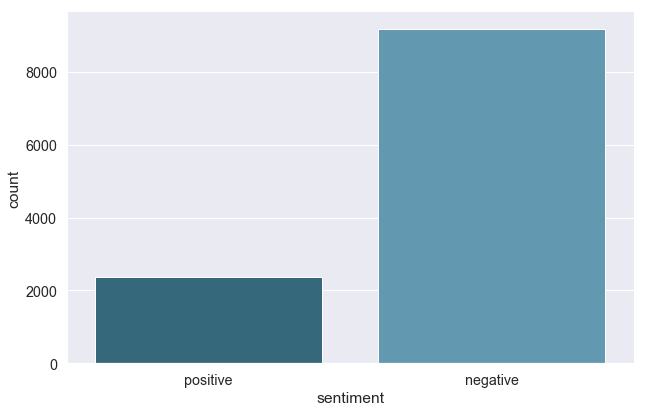

In [32]:
#Positive vs Negative 
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
sns.catplot(x="sentiment", data=data, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();


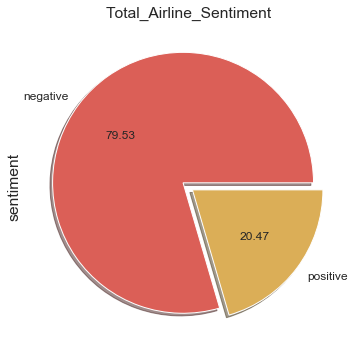

In [33]:
colors=sns.color_palette("hls", 10)
pd.Series(data["sentiment"]).value_counts().plot(kind="pie",colors=colors,labels=["negative", "positive"],explode=[0.05,0.04],shadow=True,autopct='%.2f', fontsize=12,figsize=(6, 6),title = "Total_Airline_Sentiment")

the us airlines tweets is biased towards negative sentiment which makes sense: people usually write to complain rather than praise

# Negative reason analysis

In [34]:
data.negative_reason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64

Common reasons for negative sentiment is custuner service issue, followed by late flight. 

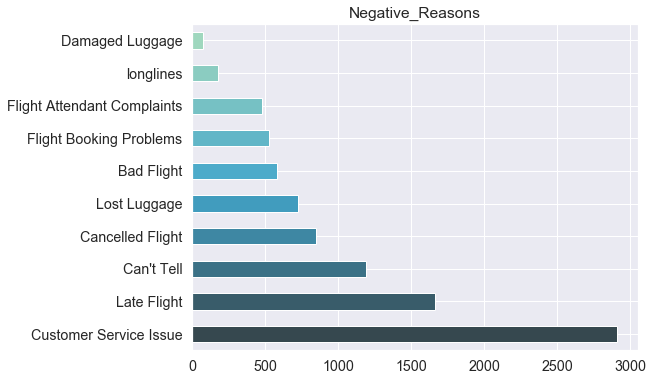

In [35]:
colors=sns.color_palette("GnBu_d", 10) 
pd.Series(data["negative_reason"]).value_counts().plot(kind = "barh",color=colors,figsize=(8,6),title = "Negative_Reasons")

# Airline Distributions

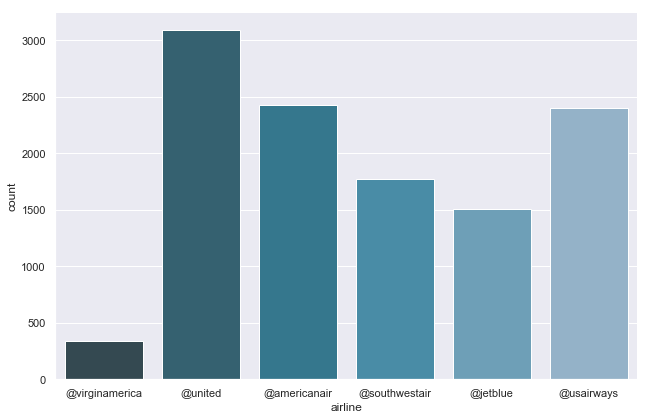

In [36]:

sns.set(style="darkgrid")
sns.set(font_scale=1.0)
sns.catplot(x="airline", data=data, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

Most tweets are from United americanair and us airways which are actually among the most known us airlines 

# Sentiment per airline

In [37]:
air_sen=pd.crosstab(data.airline, data.sentiment)
air_sen

sentiment,negative,positive
airline,,
@americanair,2081,346
@jetblue,963,545
@southwestair,1198,573
@united,2606,485
@usairways,2138,261
@virginamerica,190,152


In [38]:
percentage=air_sen.apply(lambda a: a / a.sum() * 100, axis=1)
percentage

sentiment,negative,positive
airline,,
@americanair,85.743717,14.256283
@jetblue,63.859416,36.140584
@southwestair,67.645398,32.354602
@united,84.309285,15.690715
@usairways,89.120467,10.879533
@virginamerica,55.555556,44.444444


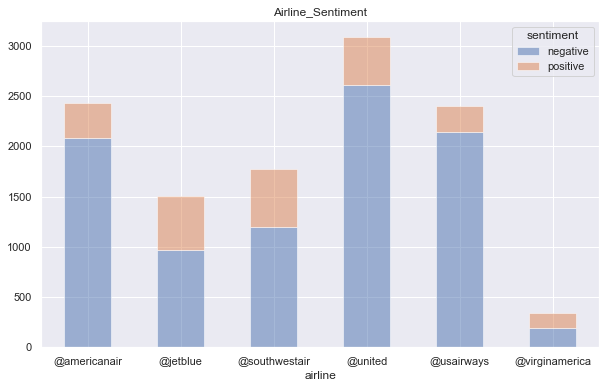

In [39]:
pd.crosstab(index = data["airline"],columns = data["sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Airline_Sentiment")

usairways, americanair and united have the largest porportion of negtive tweets 

# Retweet Recounts

In [40]:
#Let s look at the retweet recounts

In [41]:
#retweet_counts
data.retweet_count.value_counts()

0     10868
1       577
2        50
4        15
3        15
7         3
5         3
22        2
31        1
6         1
44        1
11        1
18        1
9         1
32        1
8         1
Name: retweet_count, dtype: int64

# Exploratory data analysis: columns containing NAs (no data)

In [42]:
# fill with NA cells in dataframe containing "", " " or the string NA
data.isna().sum()

id                    0
sentiment             0
negative_reason    2363
user                  0
retweet_count         0
text                  0
airline               3
dtype: int64

Here we simply drop the emply cells for negative reason but we could use imputation to infer a class for negative reason

In [43]:
#We can see tht most of the tweets are actually not retweeted. 
#A very tiny fraction of them are tweeted only once.
#However, 4 tweets have been retweeted 22, 31, 32 44  times. Let's have a look and see why they say.
pd.options.display.max_colwidth = 500
print(str(data['text'].loc[data['retweet_count'] == 22]))
print(str(data['text'].loc[data['retweet_count'] == 31]))
print(str(data['text'].loc[data['retweet_count'] == 32]))
print(str(data['text'].loc[data['retweet_count'] == 44]))

4407    beauti seattl
5396            fleet
Name: text, dtype: object
5407    stop use word compani fleet
Name: text, dtype: object
8975    cours never thank concern happen choos next time
Name: text, dtype: object
8988    delay delay land even real life plane home high heel shoe high heel shoe high heel shoe heel click
Name: text, dtype: object


The most retweeted tweets after cleaning don't even make sense to the human reader any more:
beutiful seattle is positive tweet
the second tweet is stop use word compani fleet which is a negative tweet
the third tweet is hard to infer a sentiment but reading the ooriginal tweet is very clear "@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time" (Irony that is hard to detect)
....

In [44]:
#Different classes of negative tweets
data["negative_reason"].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64

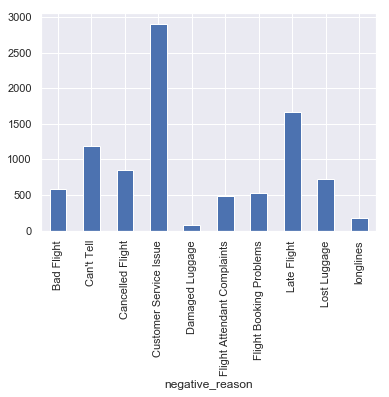

In [45]:
data.groupby("negative_reason").sentiment.count().plot.bar(ylim=0)

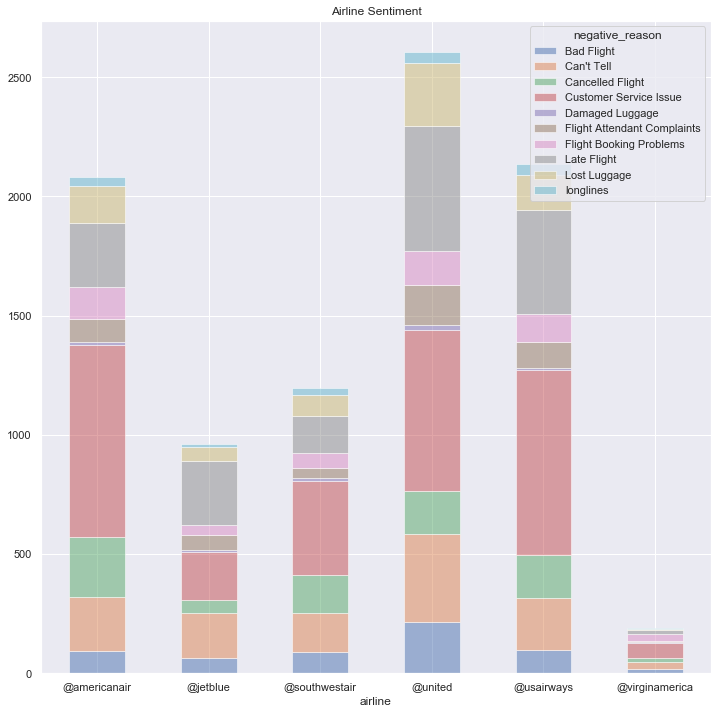

In [46]:
pd.crosstab(index = data["airline"],columns = data["negative_reason"]).plot(kind='bar',figsize=(12, 12),alpha=0.5,rot=0,stacked=True,title="Airline Sentiment")

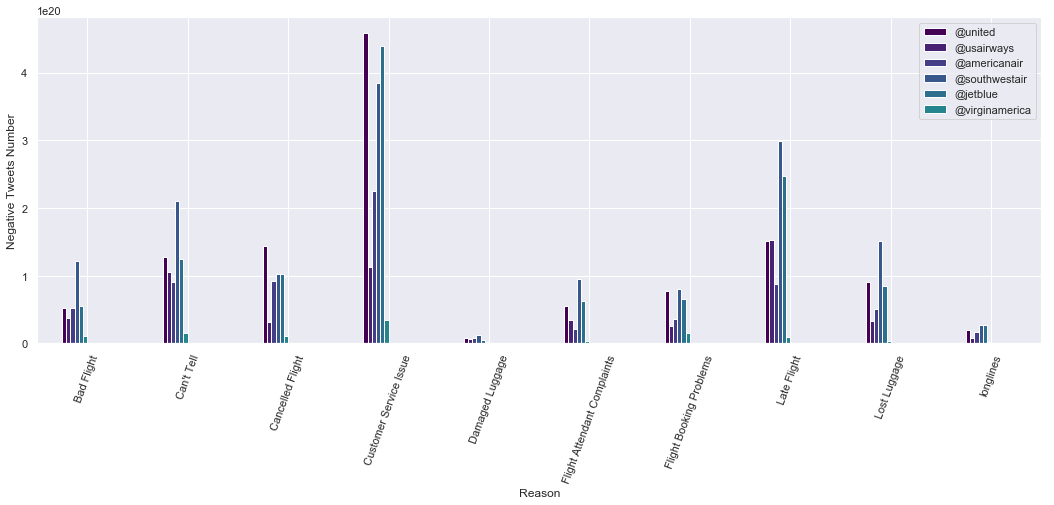

In [47]:
#groupby and plot data
ax2 = data.groupby(['negative_reason','airline']).sum().unstack().plot(kind = 'bar', colormap = 'viridis', figsize = (18,6), rot = 70)
labels = major_airlines
ax2.legend(labels = labels)
ax2.set_xlabel('Reason')
ax2.set_ylabel('Negative Tweets Number')
plt.show()

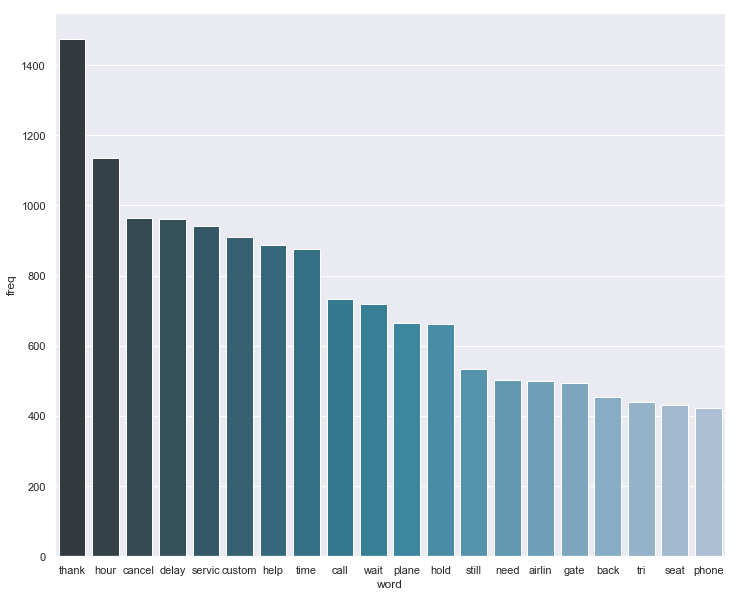

In [48]:
#print(data.text)
#Study most frequent words
cv = CountVectorizer()
bow = cv.fit_transform(data.text)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

# Part 3 :Model Preparation

In [49]:
# See the list of unique words : bag of words
# Number of unique words in current data set
data['text'].head()
#print(words_list_tokeep)
cv = CountVectorizer(words_list_tokeep)
#Passing rhe full corpus of weets
countervectorUSairline = cv.fit_transform(data['text'])

In [50]:
print(countervectorUSairline)

  (0, 444)	1
  (0, 251)	1
  (0, 17)	1
  (0, 927)	1
  (1, 714)	1
  (1, 455)	1
  (1, 567)	1
  (1, 416)	1
  (1, 146)	1
  (1, 996)	1
  (2, 1252)	1
  (2, 996)	1
  (3, 494)	1
  (3, 850)	1
  (3, 922)	1
  (3, 1086)	1
  (3, 1101)	1
  (3, 1252)	1
  (3, 996)	1
  (4, 105)	1
  (4, 1266)	1
  (4, 428)	1
  (4, 818)	1
  (5, 1367)	1
  (6, 555)	1
  :	:
  (11536, 183)	1
  (11536, 804)	1
  (11536, 819)	1
  (11536, 77)	1
  (11537, 1053)	1
  (11537, 330)	1
  (11537, 571)	1
  (11538, 220)	1
  (11538, 349)	1
  (11538, 1251)	1
  (11539, 1351)	1
  (11539, 1109)	1
  (11539, 254)	1
  (11539, 696)	1
  (11539, 689)	2
  (11539, 310)	1
  (11539, 793)	2
  (11539, 177)	1
  (11540, 1213)	1
  (11540, 252)	1
  (11540, 802)	1
  (11540, 749)	1
  (11540, 209)	1
  (11540, 906)	1
  (11540, 58)	1


In [51]:
#Convert the countervector output to a dataframe
countvectorDF_USAirline = pd.DataFrame(countervectorUSairline.toarray())
countvectorDF_USAirline.columns = cv.get_feature_names()
# Print the dataframe
print(countvectorDF_USAirline[:10])

   abil  abl  abov  absolut  absurd  abysm  accept  access  accommod  accord  \
0     0    0     0        0       0      0       0       0         0       0   
1     0    0     0        0       0      0       0       0         0       0   
2     0    0     0        0       0      0       0       0         0       0   
3     0    0     0        0       0      0       0       0         0       0   
4     0    0     0        0       0      0       0       0         0       0   
5     0    0     0        0       0      0       0       0         0       0   
6     0    0     0        0       0      0       0       0         0       0   
7     0    0     0        0       0      0       0       0         0       0   
8     0    0     0        0       0      0       0       0         0       0   
9     0    0     0        0       0      0       0       0         0       0   

   ...  wrong  wrote  yeah  year  yell  yesterday  york  young  zero  zone  
0  ...      0      0     0     0     0    

# Read the generic_tweets.csv file 

In [52]:
filename = "generic_tweets.txt"
df = pd.read_csv(filename, encoding='utf-8')
df.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [53]:
df['date'] = pd.to_datetime(df['date'])
df['Datef'] = df['date'].dt.date
df['time'] = df['date'].dt.time
df.head()

,class,id,date,query,user,text,Datef,time
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06,22:19:45
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06,22:19:49
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06,22:19:53
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06,22:19:57
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06,22:19:57


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
class    200000 non-null int64
id       200000 non-null int64
date     200000 non-null datetime64[ns]
query    200000 non-null object
user     200000 non-null object
text     200000 non-null object
Datef    200000 non-null object
time     200000 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 12.2+ MB


# Clean the data

In [55]:
df['text'] =  df['text'].apply(lambda x: cleanhtml(x))
df['text'] = df['text'].apply(lambda x:  html.unescape(x) ) 
df['text'] = df['text'].apply(lambda x: x.lower())

In [56]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['class'] = df["class"]
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,class
0,22,1,0,0,0,1,0,0
1,22,0,0,0,1,0,0,0
2,18,1,0,0,0,0,0,0
3,10,0,0,0,0,0,0,0
4,24,1,0,0,1,0,0,0


Descriptive stats for count_words
---------------------------------
          count      mean       std  min  25%   50%   75%   max
class                                                          
0      100000.0  14.04020  7.336562  1.0  8.0  13.0  20.0  48.0
4      100000.0  13.37376  7.048160  1.0  8.0  12.0  19.0  52.0


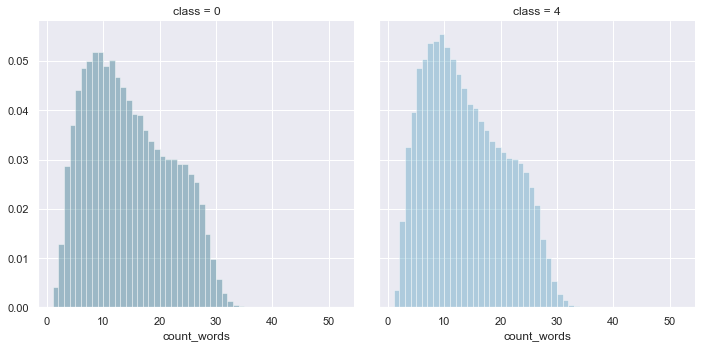

In [57]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('class')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='class', height=5, hue='class', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
show_dist(df_eda,"count_words") #Negative tweets and positive tweets do not correlate with the number of words in a single tweet 

In [58]:
#number of unique words before cleaning
token_data = df['text'].apply(lambda x: tokenization(x))
before_cleaning_number=len(set(list(itertools.chain.from_iterable(token_data))))
print(before_cleaning_number)

148162


Positive words


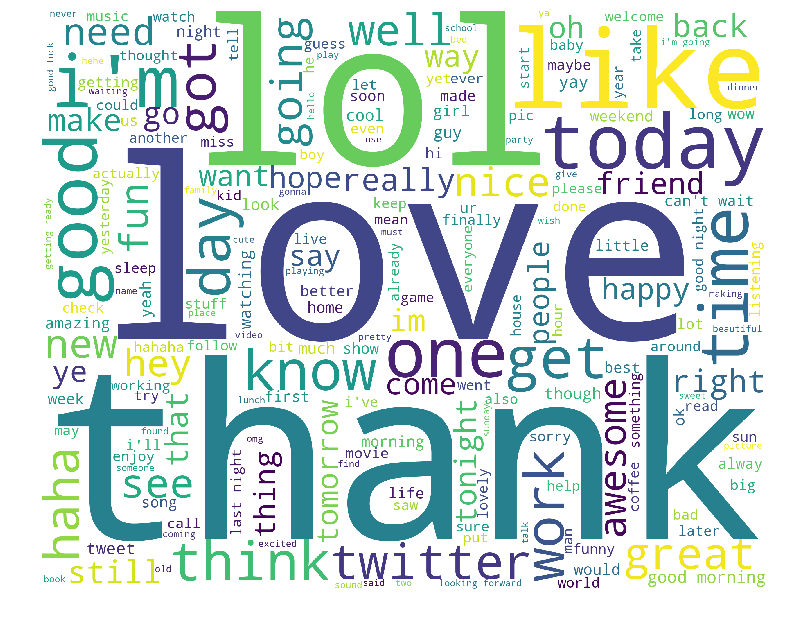

Negative words


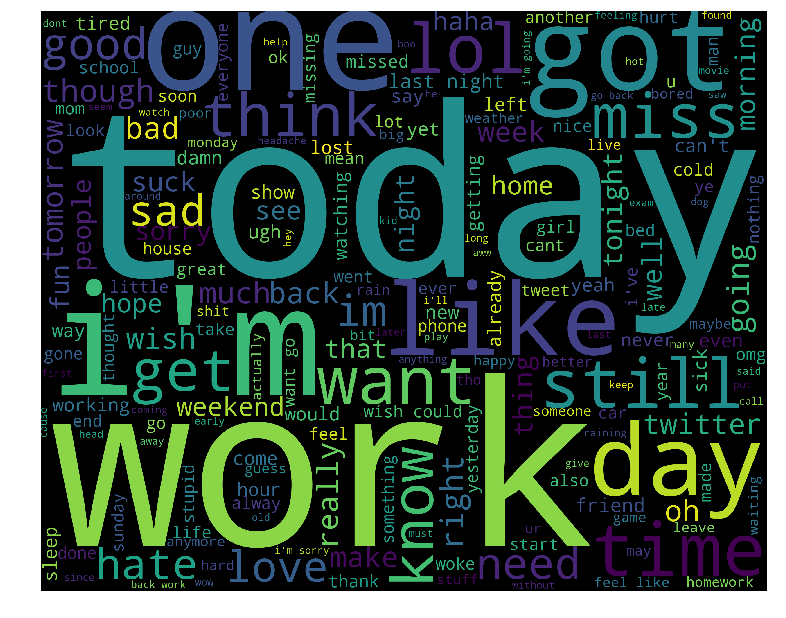

In [59]:
train_pos = df[df['class'] == 4]
train_pos = train_pos['text']
train_neg = df[df['class'] == 0]
train_neg = train_neg['text']
STOPWORDS = nltk.corpus.stopwords.words('english')
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
#                                 and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

It is unteresting to see that words associated with negative emotions are work, today...
Love and good are among the words that we would expect to see with negative emotions, but they appear with significant frequencies in the bag of words of negative tweets. I woudl assume that they appear in ronic and sarcastic tweets. 

In [60]:
#analysis of mentions 
allmentions = df['text'].str.extractall(r"(@[A-Za-z0-9]+)")
allmentions_words = allmentions[0][:]
freq_mentions = allmentions_words.value_counts(dropna=False)
print(freq_mentions)

@mileycyrus         617
@tommcfly           451
@ddlovato           418
@jonathanrknight    251
@donniewahlberg     164
@davidarchie        164
@jonasbrothers      158
@nick               156
@stephenfry         145
@aplusk             143
@jordanknight       138
@dougiemcfly        137
@the                125
@taylorswift13      123
@selenagomez        122
@joeymcintyre       119
@mariahcarey        104
@dannywood          100
@petewentz           97
@iamdiddy            96
@shaundiviney        92
@heidimontag         87
@perezhilton         79
@mussomitchel        78
@gfalcone601         77
@schofe              76
@miss                76
@britneyspears       75
@wossy               71
@mrskutcher          69
                   ... 
@nanilani254          1
@stimpy911            1
@kelliephayer         1
@varcoleman           1
@ohdatsbeezy          1
@catsss               1
@brehaut              1
@jazred87             1
@sammeh               1
@awoods               1
@marpagan       

In [61]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
def mention_extract(x):
    mentions = []
    for i in x:
        mt = re.findall(r"@(\w+)", i)
        mentions.append(mt)
    return mentions
# extracting hashtags from positive 
HT_pos = hashtag_extract(train_pos)
# extracting hashtags from negative tweets
HT_neg = hashtag_extract(train_neg)# extracting hashtags from negative tweets
mt_pos = mention_extract(train_pos)
# extracting mentions from negative tweets
mt_neg = mention_extract(train_neg)
# unnesting list
HT_pos = sum(HT_pos,[])
HT_neg = sum(HT_neg,[])
mt_pos = sum(mt_pos,[])
mt_neg = sum(mt_neg,[])

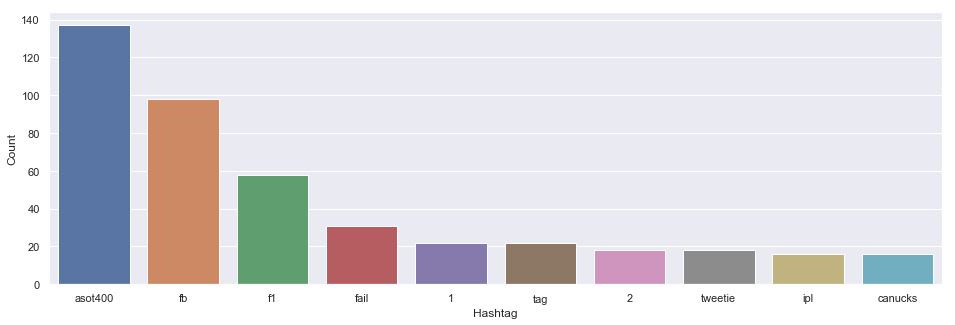

In [62]:
#Positive tweets 
a = nltk.FreqDist(HT_neg)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
#selecting 20 most frequent hashtags for negative tweets
d= d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel="Count")
plt.show()

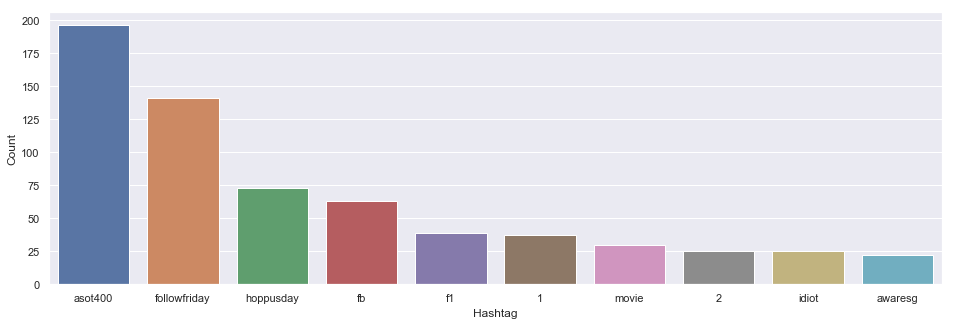

In [63]:
#Negative tweets 
a = nltk.FreqDist(HT_pos)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
#selecting 20 most frequent hashtags for positive tweets
d= d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel="Count")
plt.show()

Mentions here don't seem to correlate with emotion

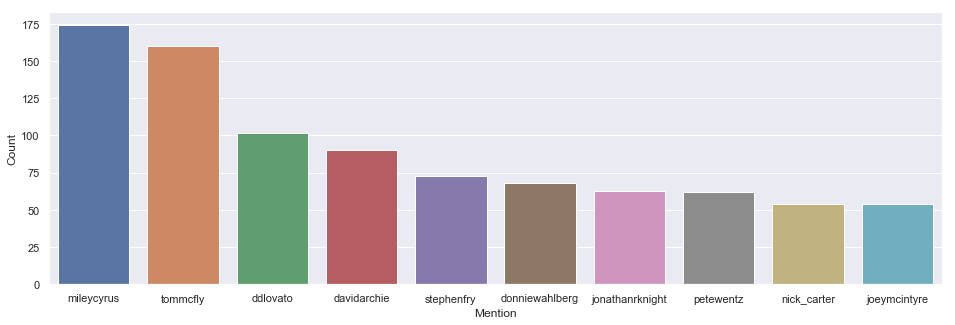

In [64]:
a = nltk.FreqDist(mt_neg)
d = pd.DataFrame({'Mention': list(a.keys()),
                  'Count': list(a.values())})
#selecting 20 most frequent mentions for negative tweets
d= d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Mention", y="Count")
ax.set(ylabel="Count")
plt.show()

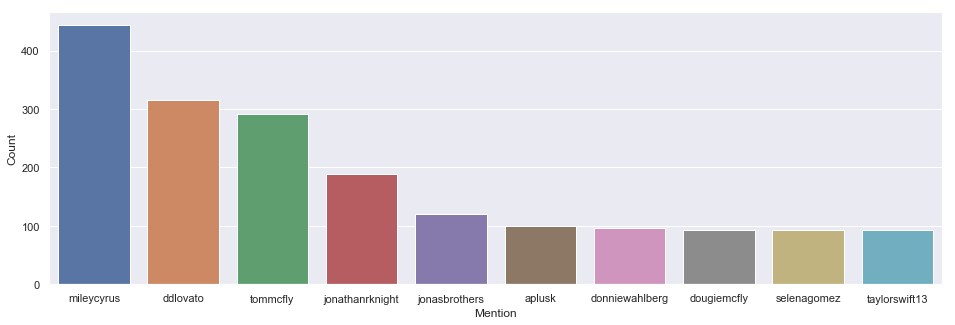

In [65]:
a = nltk.FreqDist(mt_pos)
d = pd.DataFrame({'Mention': list(a.keys()),
                  'Count': list(a.values())})
#selecting 20 most frequent mentions for positive tweets
d= d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Mention", y="Count")
ax.set(ylabel="Count")
plt.show()

mention refers to celebraties and indicate that a good portion of tweets are about american celebraties and mixed feelings about them
We could examine the proportion of negative tweets for each celebraty.
In any case, the mentions are ignored because they don't matter that much in identifying the emotions

In [66]:
#remove stop words and additional cleaning
df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df['text'] = df['text'].apply(lambda x:  fix_text(x) ) 
df['text'] = df['text'].replace(r"@[A-Za-z0-9]+", '', regex=True)
df['text'] = df['text'].replace(r"#[A-Za-z0-9]+", '', regex=True)
df['text'] = df['text'].apply(lambda x:  emoji.demojize(x) ) 
stop = [line.rstrip('\n') for line in open('stop_words.txt')]
df['text'].apply(lambda x: ''.join([word for word in x.split() if word not in stop]))
df['text'] = df['text'].apply(lambda x: emoji_oneword(x))    
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
df['text'] = df['text'].apply(lambda x: remove_digits(x))
df['text'] = df['text'].apply(lambda x: remove_add_space(x))
df['text'] = df['text'].apply(lambda x: remove_non_english(x))
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df['text'] = df['text'].apply(lambda x: stemming(x))
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text'].sample(15)

136833                                          yesss
137691                        carrot orang cupcak ice
25254       honey discov find messag discov late back
118                            hang crooner sing suck
165915    hug speechless call fucker veri endear term
123114                  control stomach hurt laughter
17907                                          suffer
49299                                            cold
283                                        work upset
62627     find word show samara nobodi attend concert
194794        wake earli start summer term good night
38358                           wish fall asleep tire
118494                   point laugh peopl work sweat
48287                                  want back long
55991                                            know
Name: text, dtype: object

In [67]:
# Number of unique words in generic tweets data set after cleaning
TokenDataSet = df['text'].apply(lambda x: tokenization(x))
TokenDataSetF = list(itertools.chain.from_iterable(TokenDataSet))
after_cleaning_number=len(set(TokenDataSetF))
print(after_cleaning_number)

16839


In [68]:
flat_list = list(itertools.chain.from_iterable(TokenDataSet))
finald = nltk.FreqDist(flat_list)
words_tokeep = list(filter(lambda x: 20000>x[1]>5, finald.items()))
words_list_tokeep_gen = [item[0] for item in words_tokeep]
def remove_lessfreq(input_text):
    words = input_text.split() 
    text_out = [word for word in words if word in words_list_tokeep_gen]
    return " ".join(text_out)
df['text']= df['text'].apply(lambda x: remove_lessfreq(x))
print(len(words_list_tokeep_gen))

7003


In [ ]:
By re moving the outliners in the bag of words we reduce the number of features from 16839 to 7003 

Positive words


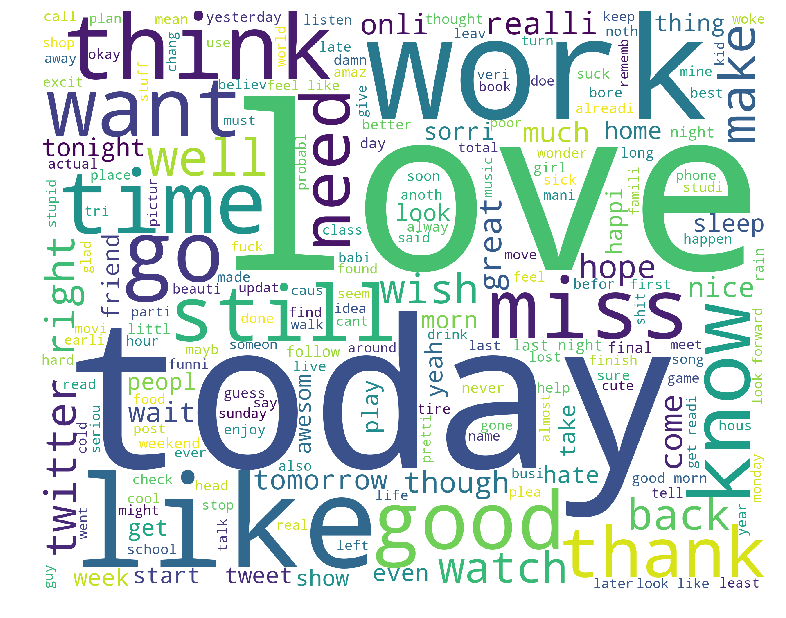

Negative words


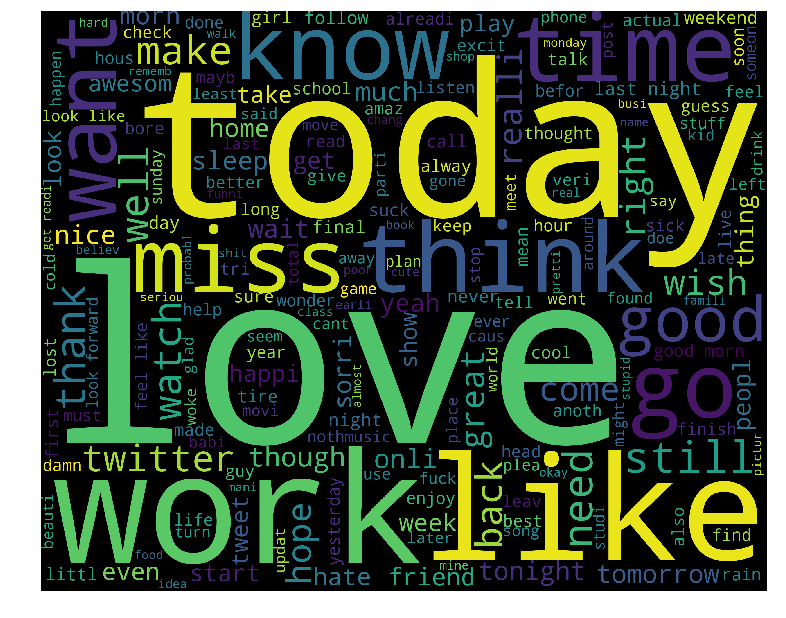

In [69]:
train_pos = df[df['class'] == 4]
train_pos = df['text']
train_neg = df[df['class'] == 0]
train_neg = df['text']
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# Exploratory analysis

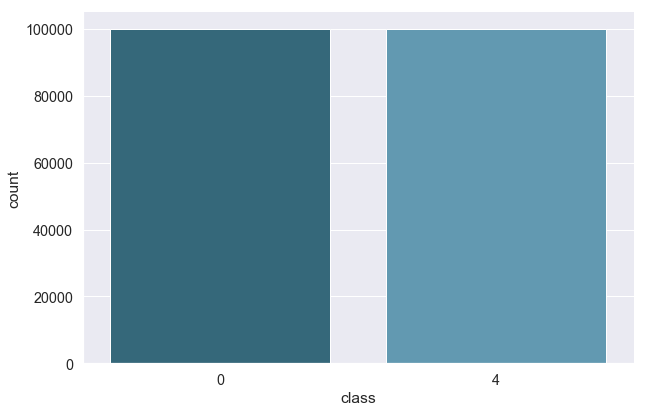

In [70]:
#Positive vs Negative 
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
sns.catplot(x="class", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

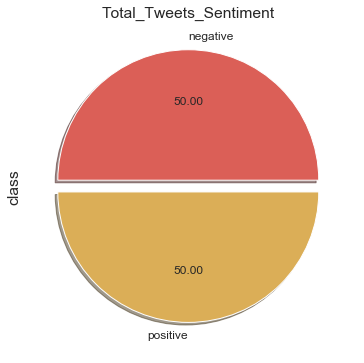

In [71]:
colors=sns.color_palette("hls", 10)
pd.Series(df["class"]).value_counts().plot(kind="pie",colors=colors,labels=["negative", "positive"],explode=[0.05,0.04],shadow=True,autopct='%.2f', fontsize=12,figsize=(6, 6),title = "Total_Tweets_Sentiment")

The generic tweet dataset is balanced and contains half engative and half positive tweets 

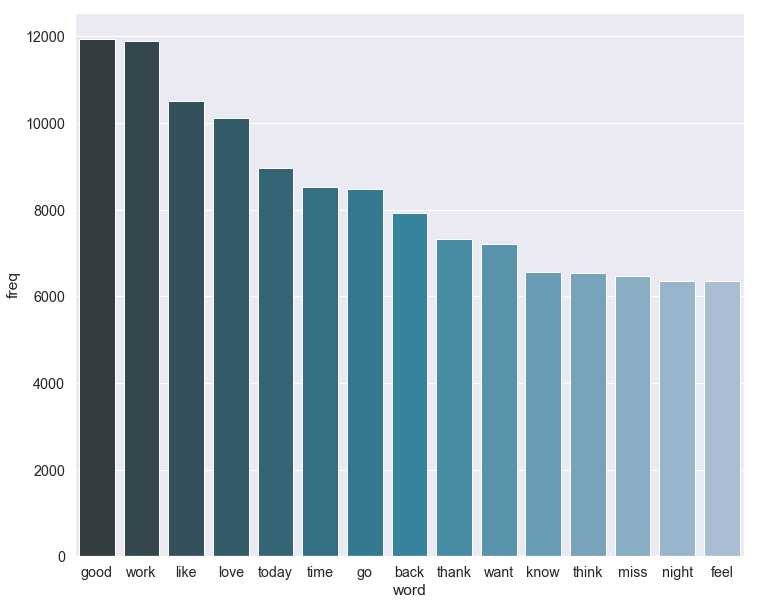

In [72]:
#Study most frequent words
cv = CountVectorizer()
bow = cv.fit_transform(df.text)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(15), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [ ]:
The top most frequent words contain words that may infer emotions and other that don't

TFIDF (Frequency-Inverse Document Frequency)vectorizer and Count Vectorizer are two common methods  to convert textual data to numeric form. Count Vectorizer look ar term frequency for all tweets. The TFIDF vectorizer is the product of these two terms; TF and IDF. TF is the relative term frequency calculated for each term within each document as below. IDF is Inverse Document Frequency, which measures how important a word is to differentiate each document

In [73]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df.text).toarray()
labels = df["text"]
N = 5
category_id = df['class'].drop_duplicates()
for nreason in category_id:
  features_chi2 = chi2(features, labels == nreason)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(nreason))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. haunt
. haul
. hatr
. hater
. zurich
  . Most correlated bigrams:
. hate happen
. hate hair
. hate guy
. hate goodby
. hate last
# '4':
  . Most correlated unigrams:
. haunt
. haul
. hatr
. hater
. zurich
  . Most correlated bigrams:
. hate happen
. hate hair
. hate guy
. hate goodby
. hate last


There are Several drawbacks to using only single words as features. Negations, such as "not bad" or "not good" for example, will not be taken into account. In fact single word features can even lead to misclassification. Using frequent n-grams as features in addition to single words can overcome this problem.

Loking above at the most correlated unigrams and bigrams for negative and positive sentiments
we identify county names such as zurich that should be removed in cleaning part 
huant , haul, hatr and hate were identified for both positive and negative tweets which is weird

In [74]:
# get most common words in training dataset
all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
collections.Counter(all_words).most_common(20)

[('good', 11949),
 ('work', 11884),
 ('like', 10503),
 ('love', 10126),
 ('today', 8951),
 ('time', 8521),
 ('go', 8479),
 ('back', 7928),
 ('thank', 7325),
 ('want', 7199),
 ('know', 6551),
 ('think', 6529),
 ('miss', 6464),
 ('night', 6347),
 ('feel', 6346),
 ('realli', 6238),
 ('hope', 5699),
 ('still', 5579),
 ('need', 5549),
 ('watch', 5438)]

We start by using the countvectorizer with logistic regression model

In [75]:
cv2 = CountVectorizer(binary=False)
cv2.fit(df['text'])
XX = cv.transform(df['text'])
yy = df['class']
X_train,X_test,y_train,y_test = train_test_split(XX,yy,test_size=0.3,random_state=0)

In [76]:
for c in [0.001, 0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.001: 0.7055666666666667
Accuracy for C=0.01: 0.7255166666666667
Accuracy for C=0.05: 0.7362666666666666
Accuracy for C=0.25: 0.7395833333333334
Accuracy for C=0.5: 0.7388333333333333
Accuracy for C=1: 0.738


Most c values give similar accuracy values and the accuracy is around 73.8%. From the confusion matrix below we see that several tweets are misclassified
We can test different models and try to improve the accuracy

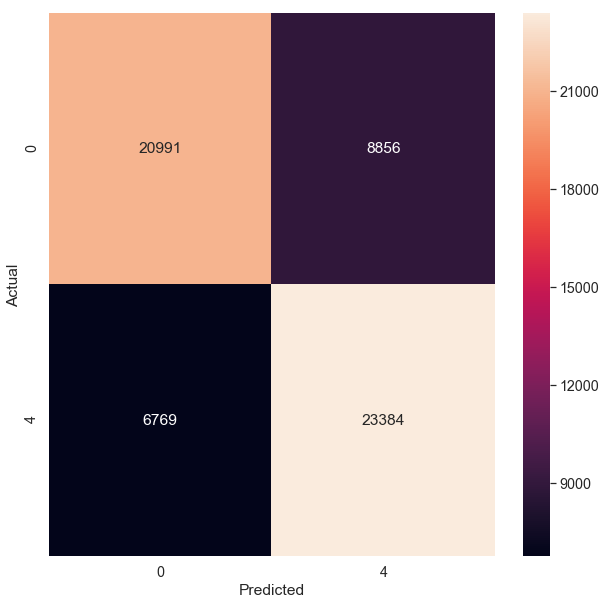

In [77]:
#Run Model 
logreg = LogisticRegression(C=0.25)
loreg = logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
category_id = df['class'].drop_duplicates()
cnf_matrix = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cnf_matrix, annot=True, fmt='d',
            xticklabels=category_id, yticklabels=category_id)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [78]:
#Evaluate Model
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     29847
           4       0.73      0.78      0.75     30153

   micro avg       0.74      0.74      0.74     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.74      0.74     60000

Accuracy: 0.7395833333333334


In [79]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv2.get_feature_names(), logreg.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('welcom', 2.120921800246355)
('smile', 1.7230262025410201)
('thank', 1.6327944607239533)
('congratul', 1.5157525804495453)
('proud', 1.4462599485792642)
('sadli', -2.4589953021060826)
('poor', -2.4448626601929573)
('lone', -2.1836547100599173)
('cancel', -2.074464880603805)
('unfortun', -2.0483367093436526)


We see that the best negative and positive words are actually well identified 

In [80]:
# In this section we use n-grams as imput features
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(df['text'])
XX = ngram_vectorizer.transform(df['text'])
X_train, X_val, y_train, y_val = train_test_split(XX, yy, train_size = 0.7)

for c in [0.001, 0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.001: 0.7034666666666667
Accuracy for C=0.01: 0.7255166666666667
Accuracy for C=0.05: 0.7379666666666667
Accuracy for C=0.25: 0.7435166666666667
Accuracy for C=0.5: 0.74445
Accuracy for C=1: 0.7424333333333333


There is a slight improvement using n-grams instead of sigle terms

In [81]:
#Test different solvers such as MultimonialNb 
for c in [0.25, 0.5, 0.75]:
    lr = MultinomialNB(alpha=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.25: 0.7169833333333333
Accuracy for C=0.5: 0.7211666666666666
Accuracy for C=0.75: 0.7234666666666667


Logistic regression is better than MultimonialNb 

In [82]:
#We decide to us LogisticRegression with  tfidfvectorizer() and logistic regression
best_mnb_tfidf = LogisticRegression(C=0.5)
best_mnb_tfidf.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
Train the model on US airline tweets 

In [83]:
#Copied from https://github.com/bertcarremans/TwitterUSAirlineSentiment
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stowords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X
ct = CleanText()
sr_clean = ct.fit_transform(df.text)

In [85]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions','count_urls','count_words']

features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                        , n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', LogisticRegression(C=0.5, penalty='l2'))])
df_eda = tc.fit_transform(df.text)
df_eda["class"] = df["class"]
df_model = df_eda
df_model['clean_text'] = df.text
df_model.columns.tolist()
best_model = pipeline.fit(df_model.drop('class', axis=1), df_model["class"])

Evaluate the quality of the prediciton

In [87]:
y_pred_airline = best_model.predict(df_model_new).tolist()

In [90]:
data["predicted class"]=y_pred_airline
data["predicted sentiment"]=data["predicted class"].map(lambda x: "negative" if (x==0) else "positive")
data["true class"]=data["sentiment"].map(lambda x: 0 if (x=="negative") else 4)
data.sample(15)

,id,sentiment,negative_reason,user,retweet_count,text,airline,predicted class,predicted sentiment,true class
3768,5.698660e+17,negative,Customer Service Issue,nelsjeff,0,late human end complet last sell,@southwestair,0,negative,0
6051,5.688820e+17,negative,Late Flight,dwhitchcock,0,delay littl commun goe long,@jetblue,0,negative,0
6273,5.684640e+17,positive,NaN,305Josec,0,fli soon airlin airlin flown still smile face smile eye smile face smile eye smile face smile eye airplan airplan airplan,@jetblue,4,positive,4
7109,5.699320e+17,negative,Late Flight,jsjonker,0,gate minut wait inform,@usairways,4,positive,0
1462,5.695550e+17,negative,Late Flight,mitchheard,0,delay vacat,@united,0,negative,0
5250,5.702390e+17,positive,NaN,nokidhungry,0,think heard amaz heard info,@jetblue,4,positive,4
7001,5.699850e+17,positive,NaN,FahadHassan,0,thank resolv issu direct,@usairways,4,positive,4
6751,5.702800e+17,negative,Flight Booking Problems,themainevent001,0,forget reserv thank great compani cancel onc thank,@usairways,4,positive,0
10644,5.698050e+17,negative,Late Flight,tessabusenius,0,alreadi time pull feel free look mani,@americanair,4,positive,0
226,5.685850e+17,negative,Flight Booking Problems,zoelle,0,tri book ticket face super broken worri keep tri,@virginamerica,0,negative,0


In [91]:
accuracy_score(data["true class"], y_pred_airline)

0.7456026340871675

We obtain an accuracy of 74% applying the model on the us airline with is around the same values we obtained for the generic tweet dataset

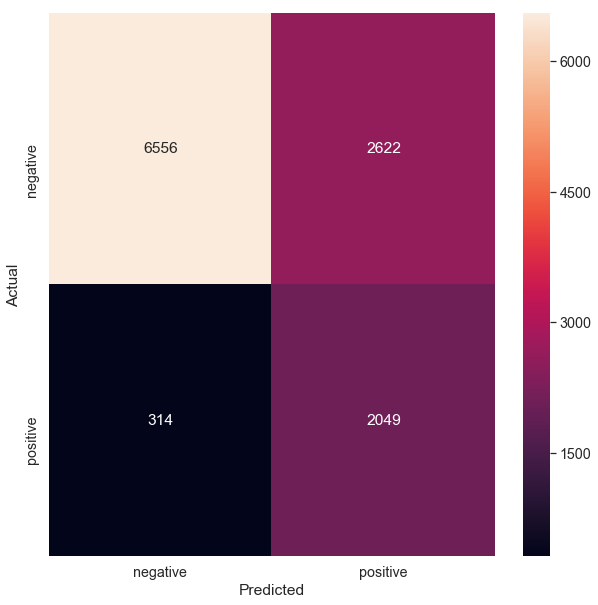

In [92]:
conf_mat = confusion_matrix(data["true class"], y_pred_airline)
#conf_mat
category_id=["negative","positive"]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id, yticklabels=category_id)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

To optimize the performance of our sentiment analysis code we considered the following as additional features"

1. Consider Punctuation, namely the exclamation point, increases the intensity. For example, “The food here is good!!!” is more intense than “The food here is good.”

2. Capitalization increases the intensity. For example, “The food here is GREAT!” conveys more intensity than “The food here is great!”
We could optimize it by considering the following :
1. Degree modifiers (also called intensifiers, booster words, or degree adverbs). For example, “The service here is extremely good” is more intense than “The service here is good”, whereas “The service here is marginally good” reduces the intensity.

2. Consider shift in sentiment words such as “but” signals a shift in sentiment, with the sentiment of the second part of the sentence being dominant. “The food here is great, but the service is horrible” has mixed sentiment, with the latter half dictating the overall rating.


# Train multi-class logistic regression model to predict the reason for the negative tweets.

In [93]:
#Only examine the data that has negative reason non empty and use  TfidfVectorizer with n-grams
data_cleaned = data.dropna(subset=['negative_reason'])
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(data_cleaned.text).toarray()
labels = data_cleaned.negative_reason
features.shape

(9178, 2312)

In [94]:
N = 2
category_id = data_cleaned['negative_reason'].drop_duplicates()
for nreason in category_id:
  features_chi2 = chi2(features, labels == nreason)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(nreason))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bad Flight':
  . Most correlated unigrams:
. seat
. wifi
  . Most correlated bigrams:
. paid wifi
. window seat
# 'Can't Tell':
  . Most correlated unigrams:
. airlin
. fleet
  . Most correlated bigrams:
. airlin ever
. worst airlin
# 'Late Flight':
  . Most correlated unigrams:
. late
. delay
  . Most correlated bigrams:
. hour delay
. delay hour
# 'Customer Service Issue':
  . Most correlated unigrams:
. servic
. custom
  . Most correlated bigrams:
. hold hour
. custom servic
# 'Flight Booking Problems':
  . Most correlated unigrams:
. mile
. book
  . Most correlated bigrams:
. book problem
. tri book
# 'Lost Luggage':
  . Most correlated unigrams:
. bag
. luggag
  . Most correlated bigrams:
. baggag claim
. lost luggag
# 'Flight Attendant Complaints':
  . Most correlated unigrams:
. staff
. attend
  . Most correlated bigrams:
. employe rude
. gate agent
# 'Cancelled Flight':
  . Most correlated unigrams:
. tomorrow
. cancel
  . Most correlated bigrams:
. cancel tomorrow
. tomorro

Here we can see that most correlated unigrams and bigrams do actually infer the class of the negative reaspn

In [95]:
category_id = data_cleaned['negative_reason'].drop_duplicates()

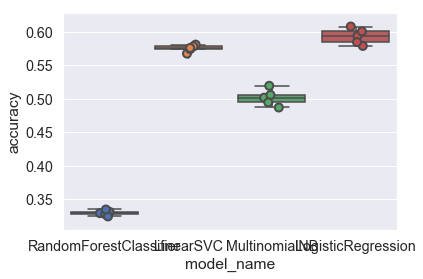

In [96]:
#Here we examine the accuracy of the following 4 models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [97]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.575290
LogisticRegression        0.593158
MultinomialNB             0.501630
RandomForestClassifier    0.329377
Name: accuracy, dtype: float64

Logistic and LinearSVC Regression perform better than the other two classifiers, with LogisticRegression having a slight advantage with a median accuracy of around 60.5788%.

In [98]:
print(features)
#print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


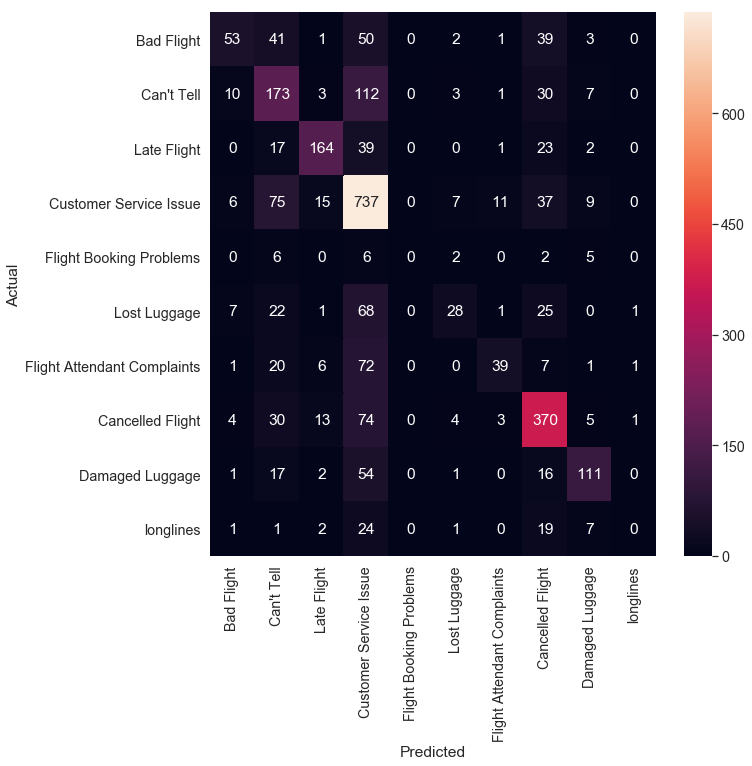

In [99]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data_cleaned.index, test_size=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
#conf_mat
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id, yticklabels=category_id)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

What we observe that for some classes such as flight booking problems and longliness we fail to identify even one class

In [100]:
print(y_train)

10291         Customer Service Issue
420           Customer Service Issue
2263          Customer Service Issue
971                      Late Flight
5406                      Can't Tell
8206                     Late Flight
10589         Customer Service Issue
2911                      Can't Tell
7172                Cancelled Flight
9358          Customer Service Issue
2612                     Late Flight
5917         Flight Booking Problems
7193                     Late Flight
9622                    Lost Luggage
992           Customer Service Issue
11496         Customer Service Issue
6500                       longlines
6997                Cancelled Flight
1013                    Lost Luggage
5556                     Late Flight
11137                     Can't Tell
976           Customer Service Issue
8423     Flight Attendant Complaints
6977                     Late Flight
2267                     Late Flight
4644                     Late Flight
7161                      Bad Flight
3

In [101]:
print(features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [102]:
print(data_cleaned.index)

Int64Index([    1,     2,     3,    11,    13,    16,    19,    20,    21,
               22,
            ...
            11526, 11528, 11530, 11531, 11533, 11535, 11536, 11537, 11539,
            11540],
           dtype='int64', length=9178)


In [103]:
new_data = data_cleaned
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(new_data['text'])
X = tokenizer_obj.texts_to_sequences(new_data['text'].values)
X = pad_sequences(X)

In [104]:
#Here we use a neural netword
# define the model
batch_size = 264
model = Sequential()
vocab_size = len(tokenizer_obj.word_index) + 1
max_length = X.shape[1]
model.add(Embedding(vocab_size, 264, input_length=max_length))
model.add(Flatten())
model.add(Dense(len(category_id), activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 264)           370392    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                79210     
Total params: 449,602
Trainable params: 449,602
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
Y = pd.get_dummies(data_cleaned['negative_reason']).values
xx_train, xx_test, yy_train, yy_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
print(xx_train.shape,yy_train.shape)
print(xx_test.shape,yy_test.shape)
num_epochs = 50
#batch_size = 256
history = model.fit(xx_train, yy_train, epochs=num_epochs, verbose=0)

(6424, 30) (6424, 10)
(2754, 30) (2754, 10)
Instructions for updating:
Use tf.cast instead.


In [106]:
accr = model.evaluate(xx_test,yy_test, verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.663
  Accuracy: 0.906


The use of neural netword do improve the accuracy siginicantly from logistic regression

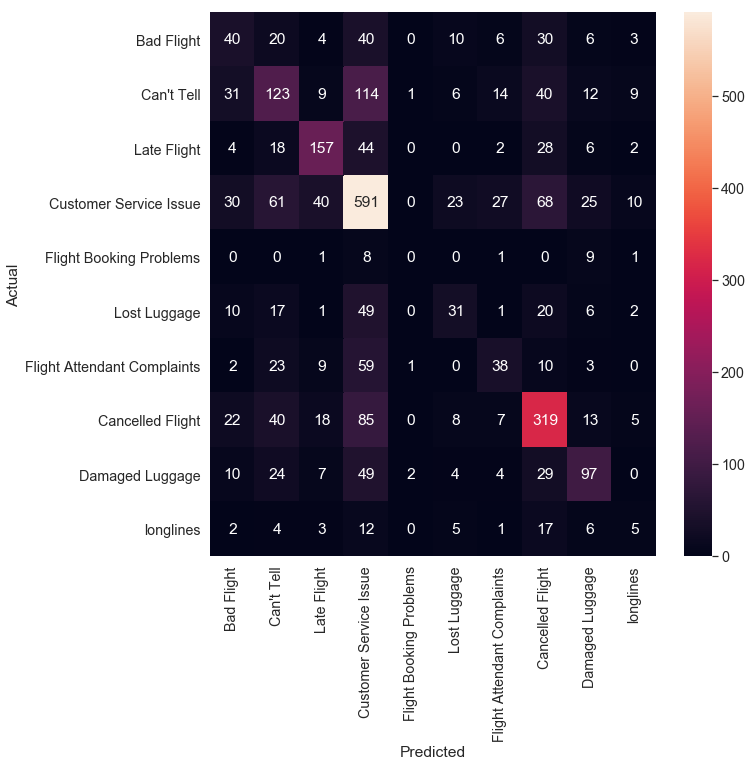

In [107]:
yy_pred = model.predict(xx_test,verbose = 0)
YY_pred = np.argmax(yy_pred, axis=1)
cm = confusion_matrix(np.argmax(yy_test,axis=1),YY_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=category_id, yticklabels=category_id)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#report = metrics.classification_report(yy_test, yy_pred, target_names=category_id)
#print(report)   

#conf_mat = metrics.confusion_matrix(yy_true , yy_pred)

We still fail to identifycategories in flight booking problems
Overall we should consider the following:
The Traditional bag-of-word model where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary could be replaced by more effetive methods. A word embedding is a class of approaches for representing words and documents using a dense vector representation.It is an improvement over more the traditional bag-of-word model encoding schemes.In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.
The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.
The position of a word in the learned vector space is referred to as its embedding.
Two popular examples of methods of learning word embeddings from text include:
Word2Vec.
GloVe.
In addition to these carefully designed methods, a word embedding can be learned as part of a deep learning model. This can be a slower approach, but tailors the model to a specific training dataseet
These approached woul be much suited into detecting irony and shift in emotions in documents